# Cantera Introduction
The following is a short run through of some cantera functionalities based on:
- [Cantera Python Tutorial](https://cantera.org/tutorials/python-tutorial.html)
- [Cantera Documentation](https://cantera.org/documentation/index.html)
- [CUSF Bamboo Cantera Example](https://github.com/cuspaceflight/bamboo/blob/master/examples/Cantera%20Example.ipynb)
- [GRI-Mech Website](http://combustion.berkeley.edu/gri-mech/)

Several reaction mechanism files (.yaml files - plain text files) are included with Cantera, including ones that model high-temperature air, a hydrogen/oxygen reaction mechanism, and a few surface reaction mechanisms.

In [8]:
import cantera as ct
import numpy as np

In [9]:
gas1 = ct.Solution('gri30.yaml') # choose mechanism for the solution

In [10]:
gas1()


  gri30:

       temperature   300 K
          pressure   1.0133e+05 Pa
           density   0.081894 kg/m^3
  mean mol. weight   2.016 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy             26469             53361  J
   internal energy       -1.2108e+06        -2.441e+06  J
           entropy             64910        1.3086e+05  J/K
    Gibbs function       -1.9447e+07       -3.9204e+07  J
 heat capacity c_p             14311             28851  J/K
 heat capacity c_v             10187             20536  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2                 1                 1           -15.717
     [  +52 minor]                 0                 0  



Thermodynamics generally requires that two properties in addition to composition information be specified to fix the intensive state of a substance (or mixture). The state of the mixture can be set using several combinations of two properties. The following are all equivalent:

In [11]:
gas1.TP = 1200, 101325           # temperature, pressure
gas1.TD = 1200, 0.0204723        # temperature, density
gas1.HP = 1.32956e7, 101325      # specific enthalpy, pressure
gas1.UV = 8.34619e6, 1/0.0204723 # specific internal energy, specific volume
gas1.SP = 85227.6, 101325        # specific entropy, pressure
gas1.SV = 85227.6, 1/0.0204723   # specific entropy, specific volume

Properties may be read independently or together:

In [12]:
print(gas1.T)
print(gas1.h)
print(gas1.UV)

1200.5188172713504
13302755.250164837
(8351530.632807602, 48.84649013545132)


The composition can be set in terms of either mole fractions (X) or mass fractions (Y). Mass and mole fractions can be set using dict objects, which is convenient in cases where the composition is stored in a variable or being computed:

In [13]:
phi = 0.8
gas1.Y = {'CH4':1, 'O2':2/phi, 'N2':2*3.76/phi} # setting mass fraction

When the composition alone is changed, the temperature and density are held constant. This means that the pressure and other intensive properties will change. The composition can also be set in conjunction with the intensive properties of the mixture:

In [14]:
gas1.TPX = 1200, 101325, 'CH4:1, O2:2, N2:7.52'
gas1()


  gri30:

       temperature   1200 K
          pressure   1.0133e+05 Pa
           density   0.28063 kg/m^3
  mean mol. weight   27.633 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        8.6193e+05        2.3818e+07  J
   internal energy        5.0087e+05        1.3841e+07  J
           entropy            8914.2        2.4633e+05  J/K
    Gibbs function       -9.8351e+06       -2.7178e+08  J
 heat capacity c_p            1397.3             38611  J/K
 heat capacity c_v            1096.4             30296  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2           0.22014           0.19011           -28.747
               CH4          0.055187          0.095057           -35.961
                N2           0.72467           0.71483           -25.67

When setting the state, you can control what properties are held constant by passing the special value None to the property setter. For example, to change the specific volume to 2.1 m3/kg while holding entropy constant:

In [15]:
gas1.SV = None, 2.1

### Chemical Equilibrium
To set a gas mixture to chemical equilibrium - a state of chemical balance in a reversible reaction - use the equilibrate method.

The below statement sets the state of object g to the state of chemical equilibrium holding temperature and pressure fixed. We can choose different options for the parameters to be held fixed. Ther are:

- <b>HP</b>: fixed enthalpy and pressure (the one we most likely will use for chamber CEA)
- <b>UV</b>: fixed specific internal energy and specific volume
- <b>SV</b>: fixed specific entropy and specific volume
- <b>SP</b>: fixed specific entropy and pressure

In [16]:
g = ct.Solution('gri30.yaml')
g.TPX = 300.0, ct.one_atm, 'CH4:0.95,O2:2,N2:7.52'
g.equilibrate('TP')

### Example of Finding Exhaust Gas Properties / Chamber Conditions

In [17]:
# Chamber conditions
_pc = 2.758e+6                # Chamber pressure (Pa)
thrust = 4448.22             # Desired thrust (N)
p_amb = 101325               # Ambient pressure (Pa) - sea level pressure
OF = 10.25                   # OF mass ratio

# We define our gas mixture via propellant initial temperature, pressure, mass ratio
gas = ct.Solution('gri30.yaml')
gas.TPY = 300, _pc, "C2H6:1, N2O:10.25"   # Very approximate fuel/ox inlet temperature
# Solution properties before chemical equilibrium
# gas()

We can plot the chmaber pressure vs OF ratio for our mixture:

In [37]:
# OF ratio:
OF = range(20)[4:] 
P = 2.758e+6 # 400 PSI
T = list()

# populate T list:
for of in OF: 
    gas = ct.Solution('gri30.yaml')
    mixture = "C2H6:1, N2O:{}".format(of)
    gas.TPY = 300, _pc, mixture
    gas.equilibrate("HP") # Equilibrate keeping enthalpy and pressure constant 
    T.append(gas.T) # add chamber temperature

C:\Users\lukas\AppData\Local\Temp/ipykernel_3692/2503033155.py:11: UserWarning: ChemEquil::equilibrate: Temperature (3004.7876734220717 K) outside valid range of 300 K to 3000 K
  gas.equilibrate("HP") # Equilibrate keeping enthalpy and pressure constant


In [38]:
print(T)

[2335.6232336490457, 2768.943214441793, 3054.1429453566807, 3214.9034280093256, 3282.14104194836, 3296.452319893097, 3285.175042986773, 3261.717172995048, 3232.3718203689573, 3200.241265728188, 3166.95644337715, 3133.4260402711493, 3100.180582532577, 3067.540413167505, 3035.702501383294, 3004.7876734220717]


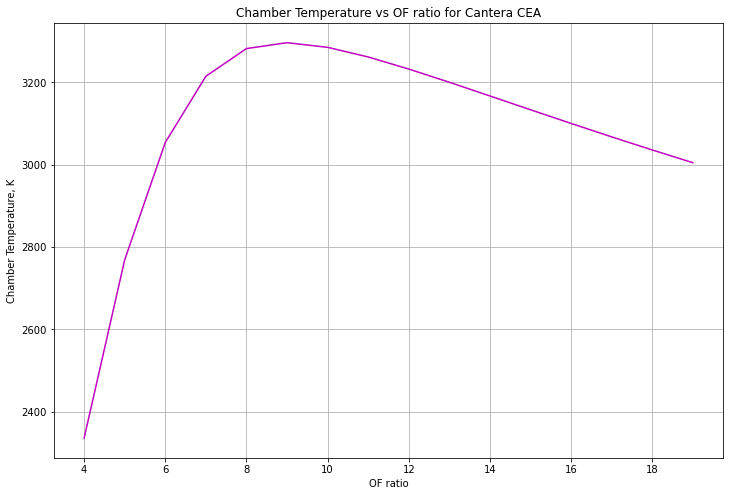

In [39]:
import os
import matplotlib.pyplot as plt
folder = "canteraplots/"
if not os.path.exists(folder):
        os.mkdir(folder)

# Plot results
fig, ax = plt.subplots(figsize=(12,8))
plt.grid()
plt.plot(OF, T, color="m")
ax.set_ylabel("Chamber Temperature, K")
ax.set_xlabel("OF ratio")
plt.title("Chamber Temperature vs OF ratio for Cantera CEA")
plt.savefig(folder + "TvsOF.png", dpi=300)